In [217]:
import tensorflow as tf
from tensorflow.keras.metrics import *
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from hausdorff import hausdorff_distance
#import lr_scheduler
from tensorflow.keras.regularizers import l2

import os
import random
import numpy as np
from tqdm import tqdm
from skimage.io import imread,imshow
from skimage.morphology import label
from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, concatenate
import sys
sys.path.append('../')
from keras_vision_transformer import swin_layers
from keras_vision_transformer import transformer_layers
from keras_vision_transformer import utils

In [218]:
TRAIN_PATH="DRIVE/training/"
TEST_PATH="DRIVE/test/"

In [219]:
train_ids=next(os.walk(TRAIN_PATH+'images/'))[2][:]
test_ids=next(os.walk(TEST_PATH+'images/'))[2][:]
print(len(train_ids))

20


In [220]:
input_height = IMG_HEIGHT = 256
input_width = IMG_WIDTH = 256
IMG_CHANNELS = 3

In [221]:

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + 'images/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img #/ 255. #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_path = TRAIN_PATH + 'mask/' + id_[:-4] + '_mask.gif'
    mask = imread(mask_path)
    mask = np.expand_dims(mask, axis=-1)
    mask = resize(mask, (input_width, input_height), mode='constant', preserve_range=True)
    mask = mask/255
    Y_train[n][mask > 0.] = 1.

print('Resizing test images and masks')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):   
    path = TEST_PATH + 'images/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img #/ 255. #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_path = TEST_PATH + 'mask/' + id_[:-4] + '_mask.gif'
    mask = imread(mask_path)
    mask = np.expand_dims(mask, axis=-1)
    mask = resize(mask, (input_width, input_height), mode='constant', preserve_range=True)
    mask = mask/255
    Y_test[n][mask > 0.] = 1.

Resizing training images and masks


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\manda\AppData\Local\Temp\ipykernel_16636\727015007.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.20it/s]


Resizing test images and masks


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\manda\AppData\Local\Temp\ipykernel_16636\727015007.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.88it/s]


In [222]:
print(X_train.shape, Y_test.shape)

(20, 256, 256, 3) (20, 256, 256, 1)


C:\Users\manda\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


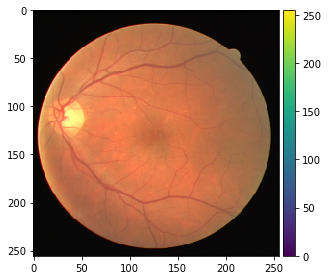

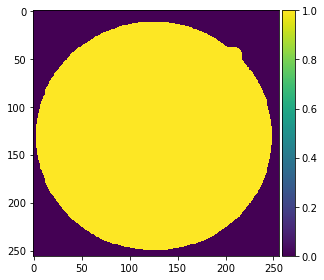

In [223]:
ix=0
imshow(X_train[ix].astype('int'))
plt.show()
imshow(np.squeeze(Y_train[ix].astype('int')))
plt.show()

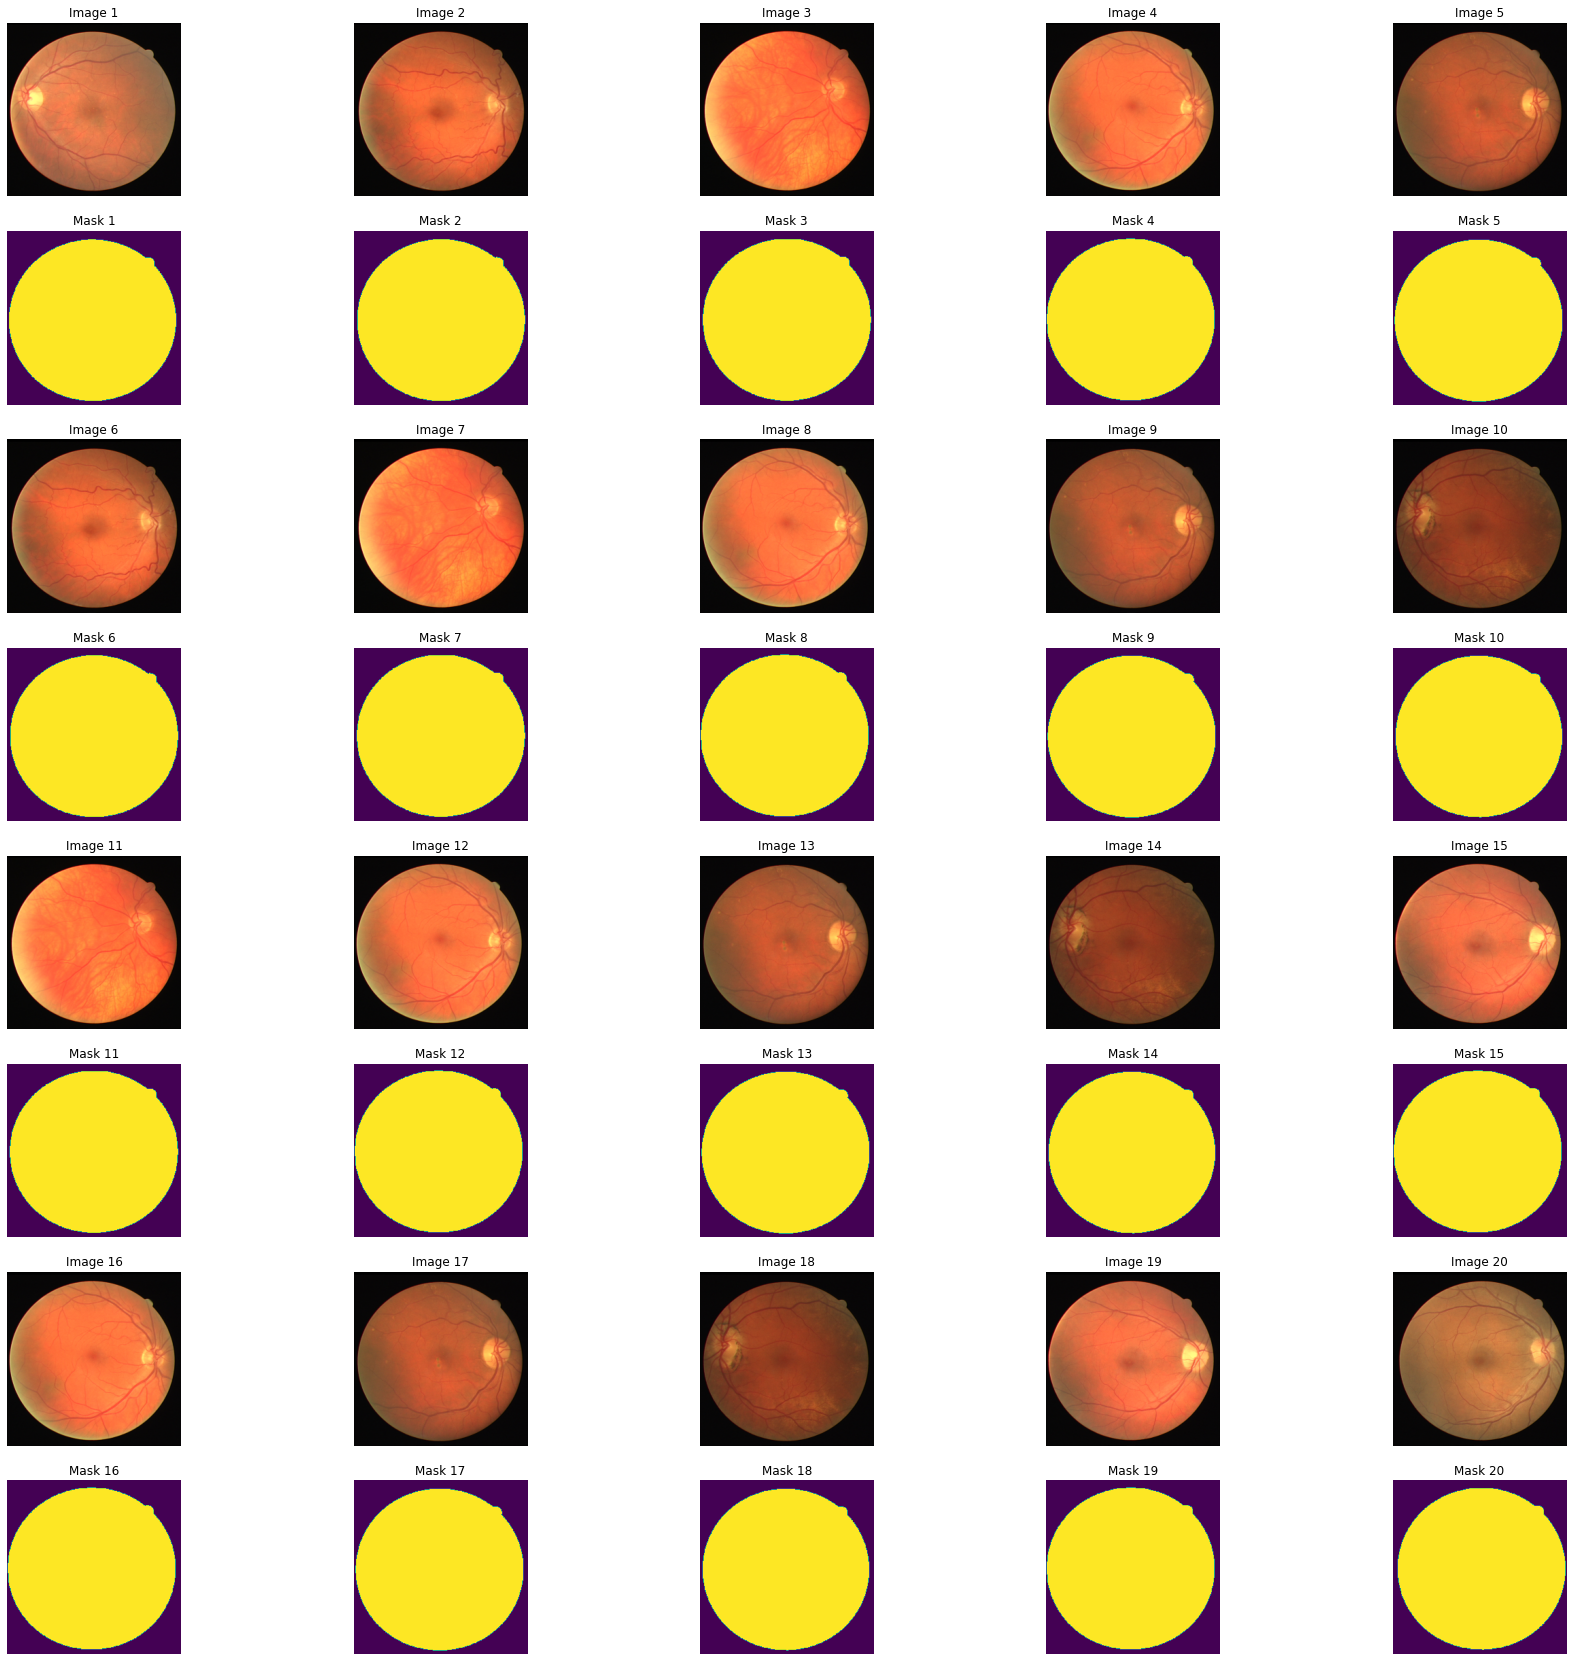

In [224]:
plt.figure(figsize=(30,30))
x, y = 5, 4
count=1
for i in range(y):
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i+j
        plt.imshow(X_train[pos].astype('int'))
        plt.title('Image {}'.format(count))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        plt.imshow(np.squeeze(Y_train[pos].astype('int')))
        plt.title('Mask {}'.format(count))
        plt.axis('off')
        count = count + 1
plt.show()

In [225]:
def expend_as(tensor, rep):
     return Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def double_conv_layer(x, filter_size, size, dropout, batch_norm=False):
    axis = 3
    conv = SeparableConv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = SeparableConv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = Dropout(dropout)(conv)

    shortcut = Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = BatchNormalization(axis=axis)(shortcut)

    res_path = add([shortcut, conv])
    return res_path

def encoder(inputs):
    num_filters = [16, 32, 64, 128]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        a = double_conv_layer(x, 3, f, 0.1, True)
        skip_connections.append(a)
        x = MaxPooling2D(pool_size=(2, 2))(a)
    
    return x, skip_connections

def bottleneck(inputs):
    x = inputs
    f = 256
    
    x3 = double_conv_layer(x, 3, f, 0.1, True)
    
    return x3

def decoder(inputs, skip_connections):
    num_filters = [128, 64, 32, 16]
    skip_connections.reverse()
    x = inputs
    batch_norm = True
    
    for i, f in enumerate(num_filters):
        
        x_up = UpSampling2D(size=(2, 2), data_format="channels_last")(x)
        x_att = concatenate([x_up, skip_connections[i]], axis=-1)
        
        x = double_conv_layer(x_att, 3, f, 0.1, True)
    return x

def output(inputs):
    x = Conv2D(1, kernel_size=(1,1))(inputs)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    
    return x


In [226]:
def swin_transformer_stack(X, stack_num, embed_dim, num_patch, num_heads, window_size, num_mlp, shift_window=True, name=''):
    '''
    Stacked Swin Transformers that share the same token size.
    
    Alternated Window-MSA and Swin-MSA will be configured if `shift_window=True`, Window-MSA only otherwise.
    *Dropout is turned off.
    '''
    # Turn-off dropouts
    mlp_drop_rate = 0 # Droupout after each MLP layer
    attn_drop_rate = 0 # Dropout after Swin-Attention
    proj_drop_rate = 0 # Dropout at the end of each Swin-Attention block, i.e., after linear projections
    drop_path_rate = 0 # Drop-path within skip-connections
    
    qkv_bias = True # Convert embedded patches to query, key, and values with a learnable additive value
    qk_scale = None # None: Re-scale query based on embed dimensions per attention head # Float for user specified scaling factor
    
    if shift_window:
        shift_size = window_size // 2
    else:
        shift_size = 0
    
    for i in range(stack_num):
    
        if i % 2 == 0:
            shift_size_temp = 0
        else:
            shift_size_temp = shift_size

        X = swin_layers.SwinTransformerBlock(dim=embed_dim, 
                                             num_patch=num_patch, 
                                             num_heads=num_heads, 
                                             window_size=window_size, 
                                             shift_size=shift_size_temp, 
                                             num_mlp=num_mlp, 
                                             qkv_bias=qkv_bias, 
                                             qk_scale=qk_scale,
                                             mlp_drop=mlp_drop_rate, 
                                             attn_drop=attn_drop_rate, 
                                             proj_drop=proj_drop_rate, 
                                             drop_path_prob=drop_path_rate, 
                                             name='name{}'.format(i))(X)
    return X

In [227]:
def swin_unet_2d_base(input_tensor, filter_num_begin, depth, stack_num_down, stack_num_up, 
                      patch_size, num_heads, window_size, num_mlp, shift_window=True, name='swin_unet'):
    '''
    The base of Swin-UNET.
    
    The general structure:
    
    1. Input image --> a sequence of patches --> tokenize these patches
    2. Downsampling: swin-transformer --> patch merging (pooling)
    3. Upsampling: concatenate --> swin-transfprmer --> patch expanding (unpooling)
    4. Model head
    
    '''
    # Compute number be patches to be embeded
    input_size = input_tensor.shape.as_list()[1:]
    num_patch_x = input_size[0]//patch_size[0]
    num_patch_y = input_size[1]//patch_size[1]
    
    # Number of Embedded dimensions
    embed_dim = filter_num_begin
    
    depth_ = depth
    
    X_skip = []

    X = input_tensor
    
    # Patch extraction
    X = transformer_layers.patch_extract(patch_size)(X)

    # Embed patches to tokens
    X = transformer_layers.patch_embedding(num_patch_x*num_patch_y, embed_dim)(X)
    
    # The first Swin Transformer stack
    X = swin_transformer_stack(X, 
                               stack_num=stack_num_down, 
                               embed_dim=embed_dim, 
                               num_patch=(num_patch_x, num_patch_y), 
                               num_heads=num_heads[0], 
                               window_size=window_size[0], 
                               num_mlp=num_mlp, 
                               shift_window=shift_window, 
                               name='{}_swin_down0'.format(name))
    X_skip.append(X)
    
    # Downsampling blocks
    for i in range(depth_-1):
        
        # Patch merging
        X = transformer_layers.patch_merging((num_patch_x, num_patch_y), embed_dim=embed_dim, name='down{}'.format(i))(X)
        
        # update token shape info
        embed_dim = embed_dim*2
        num_patch_x = num_patch_x//2
        num_patch_y = num_patch_y//2
        
        # Swin Transformer stacks
        X = swin_transformer_stack(X, 
                                   stack_num=stack_num_down, 
                                   embed_dim=embed_dim, 
                                   num_patch=(num_patch_x, num_patch_y), 
                                   num_heads=num_heads[i+1], 
                                   window_size=window_size[i+1], 
                                   num_mlp=num_mlp, 
                                   shift_window=shift_window, 
                                   name='{}_swin_down{}'.format(name, i+1))
        
        # Store tensors for concat
        X_skip.append(X)
        
    # reverse indexing encoded tensors and hyperparams
    X_skip = X_skip[::-1]
    num_heads = num_heads[::-1]
    window_size = window_size[::-1]
    
    # upsampling begins at the deepest available tensor
    X = X_skip[0]
    
    # other tensors are preserved for concatenation
    X_decode = X_skip[1:]
    
    depth_decode = len(X_decode)
    
    for i in range(depth_decode):
        
        # Patch expanding
        X = transformer_layers.patch_expanding(num_patch=(num_patch_x, num_patch_y), 
                                               embed_dim=embed_dim, 
                                               upsample_rate=2, 
                                               return_vector=True)(X)
        

        # update token shape info
        embed_dim = embed_dim//2
        num_patch_x = num_patch_x*2
        num_patch_y = num_patch_y*2
        
        # Concatenation and linear projection
        X = concatenate([X, X_decode[i]], axis=-1, name='{}_concat_{}'.format(name, i))
        X = Dense(embed_dim, use_bias=False, name='{}_concat_linear_proj_{}'.format(name, i))(X)
        
        # Swin Transformer stacks
        X = swin_transformer_stack(X, 
                                   stack_num=stack_num_up, 
                                   embed_dim=embed_dim, 
                                   num_patch=(num_patch_x, num_patch_y), 
                                   num_heads=num_heads[i], 
                                   window_size=window_size[i], 
                                   num_mlp=num_mlp, 
                                   shift_window=shift_window, 
                                   name='{}_swin_up{}'.format(name, i))
        
    # The last expanding layer; it produces full-size feature maps based on the patch size
    # !!! <--- "patch_size[0]" is used; it assumes patch_size = (size, size)
    
    X = transformer_layers.patch_expanding(num_patch=(num_patch_x, num_patch_y), 
                                           embed_dim=embed_dim, 
                                           upsample_rate=patch_size[0], 
                                           return_vector=False)(X)
    
    return X

In [228]:
def encoder(input_tensor, filter_num_begin, depth, stack_num_down, stack_num_up, 
                      patch_size, num_heads, window_size, num_mlp, shift_window=True, name='swin_unet_encoder'):
    '''
    The base of Swin-UNET.
    
    The general structure:
    
    1. Input image --> a sequence of patches --> tokenize these patches
    2. Downsampling: swin-transformer --> patch merging (pooling)
    3. Upsampling: concatenate --> swin-transfprmer --> patch expanding (unpooling)
    4. Model head
    
    '''
    # Compute number be patches to be embeded
    input_size = input_tensor.shape.as_list()[1:]
    print("input_size",input_size)
    num_patch_x = input_size[0]//patch_size[0]
    print("num_patch_x",num_patch_x)
    num_patch_y = input_size[1]//patch_size[1]
    
    # Number of Embedded dimensions
    embed_dim = filter_num_begin
    
    depth_ = depth
    
    X_skip = []

    X = input_tensor
    
    # Patch extraction
    X = transformer_layers.patch_extract(patch_size)(X)

    # Embed patches to tokens
    X = transformer_layers.patch_embedding(num_patch_x*num_patch_y, embed_dim)(X)
    
    # The first Swin Transformer stack
    X = swin_transformer_stack(X, 
                               stack_num=stack_num_down, 
                               embed_dim=embed_dim, 
                               num_patch=(num_patch_x, num_patch_y), 
                               num_heads=num_heads[0], 
                               window_size=window_size[0], 
                               num_mlp=num_mlp, 
                               shift_window=shift_window, 
                               name='{}_swin_down0'.format(name))
    X_skip.append(X)
    
    # Downsampling blocks
    for i in range(depth_-1):
        
        # Patch merging
        X = transformer_layers.patch_merging((num_patch_x, num_patch_y), embed_dim=embed_dim, name='down{}'.format(i))(X)
        
        # update token shape info
        embed_dim = embed_dim*2
        num_patch_x = num_patch_x//2
        num_patch_y = num_patch_y//2
        
        # Swin Transformer stacks
        X = swin_transformer_stack(X, 
                                   stack_num=stack_num_down, 
                                   embed_dim=embed_dim, 
                                   num_patch=(num_patch_x, num_patch_y), 
                                   num_heads=num_heads[i+1], 
                                   window_size=window_size[i+1], 
                                   num_mlp=num_mlp, 
                                   shift_window=shift_window, 
                                   name='{}_swin_down{}'.format(name, i+1))
        
        # Store tensors for concat
        X_skip.append(X)
        
    
    
    return X, X_skip, embed_dim, num_patch_x, num_patch_y

def bottleneck(inputs):
    x = inputs
    f = 256
    
    x3 = double_conv_layer(x, 3, f, 0.1, True)
    
    return x3

def decoder(inputs, skip_connections):
    num_filters = [128, 64, 32, 16]
    skip_connections.reverse()
    x = inputs
    batch_norm = True
    
    for i, f in enumerate(num_filters):
        
        x_up = UpSampling2D(size=(2, 2), data_format="channels_last")(x)
        x_att = concatenate([x_up, skip_connections[i]], axis=-1)
        
        x = double_conv_layer(x_att, 3, f, 0.1, True)
    return x

def s_decoder(embed_dim,num_patch_x,num_patch_y, X_skip,filter_num_begin, depth, stack_num_down, stack_num_up, 
                      patch_size, num_heads, window_size, num_mlp, shift_window=True,name='swin_decoder'):
    #input_size = [256,256,3]
    #num_patch_x = input_size[0]//patch_size[0]
    #print("numPatchX",num_patch_x)
    #num_patch_y = input_size[1]//patch_size[1]
    #print("numPatchY",num_patch_y)
    # Number of Embedded dimensions
    #embed_dim = filter_num_begin
    
    depth_ = depth
    # reverse indexing encoded tensors and hyperparams
    X_skip = X_skip[::-1]
    num_heads = num_heads[::-1]
    window_size = window_size[::-1]
    
    
    
    # upsampling begins at the deepest available tensor
    X = X_skip[0]
    print("X_skip0",X)
    # other tensors are preserved for concatenation
    X_decode = X_skip[1:]
    print("X-decode", X_decode)
    
    depth_decode = len(X_decode)
    print("depth_decode nnnnnnnnnnnn",depth_decode)
    for i in range(depth_decode):
        
        # Patch expanding
        X = transformer_layers.patch_expanding(num_patch=(num_patch_x, num_patch_y), 
                                               embed_dim=embed_dim, 
                                               upsample_rate=2, 
                                               return_vector=True)(X)
        

        # update token shape info
        embed_dim = embed_dim//2
        num_patch_x = num_patch_x*2
        num_patch_y = num_patch_y*2
        
        # Concatenation and linear projection
        X = concatenate([X, X_decode[i]], axis=-1, name='{}_concat_{}'.format(name, i))
        X = Dense(embed_dim, use_bias=False, name='{}_concat_linear_proj_{}'.format(name, i))(X)
        
        # Swin Transformer stacks
        X = swin_transformer_stack(X, 
                                   stack_num=stack_num_up, 
                                   embed_dim=embed_dim, 
                                   num_patch=(num_patch_x, num_patch_y), 
                                   num_heads=num_heads[i], 
                                   window_size=window_size[i], 
                                   num_mlp=num_mlp, 
                                   shift_window=shift_window, 
                                   name='{}_swin_up{}'.format(name, i))
        
    # The last expanding layer; it produces full-size feature maps based on the patch size
    # !!! <--- "patch_size[0]" is used; it assumes patch_size = (size, size)
    
    X = transformer_layers.patch_expanding(num_patch=(num_patch_x, num_patch_y), 
                                           embed_dim=embed_dim, 
                                           upsample_rate=patch_size[0], 
                                           return_vector=False)(X)
    
    return X
    
    
    
    
    

def output(inputs):
    x = Conv2D(1, kernel_size=(1,1))(inputs)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    
    return x


In [229]:
filter_num_begin = 128     # number of channels in the first downsampling block; it is also the number of embedded dimensions
depth = 4               # the depth of SwinUNET; depth=4 means three down/upsampling levels and a bottom level 
stack_num_down = 2         # number of Swin Transformers per downsampling level
stack_num_up = 2           # number of Swin Transformers per upsampling level
patch_size = (4, 4)        # Extract 4-by-4 patches from the input image. Height and width of the patch must be equal.
num_heads = [4, 8, 8, 8]   # number of attention heads per down/upsampling level
window_size = [4, 2, 2, 2] # the size of attention window per down/upsampling level
num_mlp = 512              # number of MLP nodes within the Transformer
shift_window=True          # Apply window shifting, i.e., Swin-MSA

In [230]:
def random_resize_crop(image, scale=[0.75, 1.0], crop_size=128):
    if crop_size == 32:
        image_shape = 48
        image = tf.image.resize(image, (image_shape, image_shape))
    else:
        image_shape = 96
        image = tf.image.resize(image, (image_shape, image_shape))
    size = tf.random.uniform(
        shape=(1,),
        minval=scale[0] * image_shape,
        maxval=scale[1] * image_shape,
        dtype=tf.float32,
    )
    size = tf.cast(size, tf.int32)[0]
    crop = tf.image.random_crop(image, (size, size, 3))
    crop_resize = tf.image.resize(crop, (crop_size, crop_size))
    return crop_resize

def flip_random_crop(image):
    image = tf.image.random_flip_left_right(image)
    image = random_resize_crop(image, crop_size=CROP_TO)
    return image


@tf.function
def float_parameter(level, maxval):
    return tf.cast(level * maxval / 10.0, tf.float32)


@tf.function
def sample_level(n):
    return tf.random.uniform(shape=[1], minval=0.1, maxval=n, dtype=tf.float32)

def rotation(image):
    augmented_image = tf.image.rot90(image)
    return augmented_image

@tf.function
def solarize(image, level=6):
    threshold = float_parameter(sample_level(level), 1)
    return tf.where(image < threshold, image, 255 - image)

def color_jitter(x, strength=0.5):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength)
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength, upper=1 + 0.8 * strength
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength, upper=1 + 0.8 * strength
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength)
    x = tf.clip_by_value(x, 0, 255)
    return x


def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image):
    image = tf.cast(image, tf.float32)
    image = flip_random_crop(image)
    image = random_apply(rotation, image, p=0.5)
    #image = random_apply(color_jitter, image, p=0.9)
    #image = random_apply(color_drop, image, p=0.3)
    #image = random_apply(solarize, image, p=0.3)
    return image

In [231]:
AUTO = tf.data.AUTOTUNE
CROP_TO = IMG_HEIGHT
SEED = 42
BATCH_SIZE = 4
ssl_ds_one = tf.data.Dataset.from_tensor_slices(X_train)
ssl_ds_one = (
    ssl_ds_one.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

ssl_ds_two = tf.data.Dataset.from_tensor_slices(X_train)
ssl_ds_two = (
    ssl_ds_two.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# We then zip both of these datasets.
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

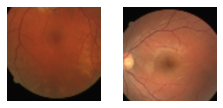

In [232]:
sample_images_one = next(iter(ssl_ds_one))
plt.figure(figsize=(10, 10))
for n in range(2):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_one[n].numpy().astype("int"))
    #print(sample_images_one[n].numpy().shape)
    plt.axis("off")
plt.show()

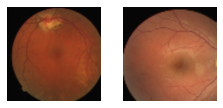

In [233]:
sample_images_two = next(iter(ssl_ds_two))
plt.figure(figsize=(10, 10))
for n in range(2):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_two[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

In [234]:
def off_diagonal(x):
    n = tf.shape(x)[0]
    flattened = tf.reshape(x, [-1])[:-1]
    off_diagonals = tf.reshape(flattened, (n-1, n+1))[:, 1:]
    return tf.reshape(off_diagonals, [-1])


def normalize_repr(z):
    z_norm = (z - tf.reduce_mean(z, axis=0)) / tf.math.reduce_std(z, axis=0)
    return z_norm


def compute_loss(z_a, z_b, lambd):
    # Get batch size and representation dimension.
    batch_size = tf.cast(tf.shape(z_a)[0], z_a.dtype)
    repr_dim = tf.shape(z_a)[1]

    # Normalize the representations along the batch dimension.
    z_a_norm = normalize_repr(z_a)
    z_b_norm = normalize_repr(z_b)

    # Cross-correlation matrix.
    c = tf.matmul(z_a_norm, z_b_norm, transpose_a=True) / batch_size

    # Loss.
    on_diag = tf.linalg.diag_part(c) + (-1)
    on_diag = tf.reduce_sum(tf.pow(on_diag, 2))
    off_diag = off_diagonal(c)
    off_diag = tf.reduce_sum(tf.pow(off_diag, 2))
    loss = on_diag + (lambd * off_diag)
    return loss 

In [235]:
class BarlowTwins(tf.keras.Model):
    def __init__(self, encoder, lambd=5e-3):
        super(BarlowTwins, self).__init__()
        self.encoder = encoder
        self.lambd = lambd
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z_a, z_b = self.encoder(ds_one, training=True), self.encoder(ds_two, training=True)
            loss = compute_loss(z_a, z_b, self.lambd) 

        # Compute gradients and update the parameters.
        gradients = tape.gradient(loss, self.encoder.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.encoder.trainable_variables))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [236]:
class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Implements an LR scheduler that warms up the learning rate for some training steps
    (usually at the beginning of the training) and then decays it
    with CosineDecay (see https://arxiv.org/abs/1608.03983)
    """

    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

In [237]:
PROJECT_DIM = IMG_HEIGHT/2
BATCH_SIZE = 8
EPOCHS = 100
WEIGHT_DECAY = 5e-4
TRAIN_FLG = 1 # 0 - No Training, 1 - Training
val_split = 0.3

STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE
TOTAL_STEPS = STEPS_PER_EPOCH * EPOCHS
WARMUP_EPOCHS = int(EPOCHS * 0.1)
WARMUP_STEPS = int(WARMUP_EPOCHS * STEPS_PER_EPOCH)

lr_decayed_fn = WarmUpCosine(
    learning_rate_base=1e-3,
    total_steps=EPOCHS * STEPS_PER_EPOCH,
    warmup_learning_rate=0.0,
    warmup_steps=WARMUP_STEPS
)

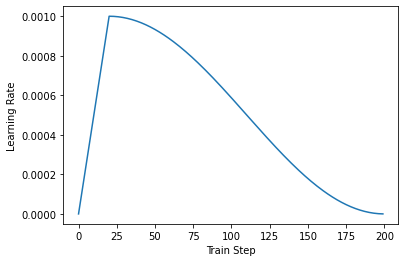

In [238]:
# Visualize the LR schedule
plt.plot(lr_decayed_fn(tf.range(EPOCHS*STEPS_PER_EPOCH, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

In [239]:
def projection_head(x, hidden_dim=128):
    """Constructs the projection head."""
    for i in range(2):
        x = Dense(
            hidden_dim,
            name=f"projection_layer_{i}",
            kernel_regularizer=l2(WEIGHT_DECAY),
        )(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    outputs = Dense(hidden_dim, name="projection_output")(x)
    return outputs

def build_encoder(shape, hidden_dim=128):
    inputs = Input(shape)
    s = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    #s = inputs
    x, skip_1,embed_dim_1,num_patch_x_1,num_patch_y_1 = encoder(s,filter_num_begin, depth, stack_num_down, stack_num_up, 
                      patch_size, num_heads, window_size, num_mlp, shift_window=True)
    
    #x = bottleneck(x)
    
    # Projections
    trunk_output = Flatten()(x)
    print("trunk_output",trunk_output)
    projection_outputs = projection_head(trunk_output, hidden_dim=hidden_dim)

    model = Model(inputs, projection_outputs)
    return model, skip_1,embed_dim_1,num_patch_x_1,num_patch_y_1

In [240]:
unet_enc, skip_connetions,embed_dim_1,num_patch_x_1,num_patch_y_1= build_encoder((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), hidden_dim=PROJECT_DIM)
unet_enc.summary()

input_size [256, 256, 3]
num_patch_x 64
trunk_output KerasTensor(type_spec=TensorSpec(shape=(None, 65536), dtype=tf.float32, name=None), name='flatten_5/Reshape:0', description="created by layer 'flatten_5'")
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_9 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 patch_extract_9 (patch_extr  (None, 4096, 48)         0         
 act)                                                            
                                                                 
 patch_embedding_9 (patch_em  (None, 4096, 128)        530560    
 bedding)                                                        
                                               

Training
Epoch 1/2
5/5 [==============================] - 111s 16s/step - loss: 172.3406
Epoch 2/2
5/5 [==============================] - 88s 17s/step - loss: 91.3976


INFO:tensorflow:Assets written to: barlow_twins_unet\assets


INFO:tensorflow:Assets written to: barlow_twins_unet\assets


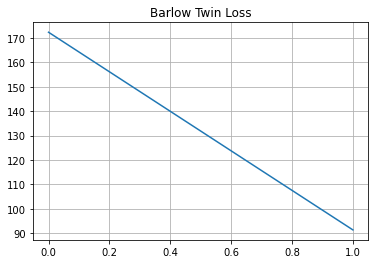

In [241]:
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn, momentum=0.9)
barlow_twins = BarlowTwins(unet_enc)
barlow_twins.compile(optimizer=optimizer)
if TRAIN_FLG:
    print("Training")
    barlow_twins.encoder.get_weights()[0]
    history = barlow_twins.fit(ssl_ds, epochs=2)
    barlow_twins.encoder.save('barlow_twins_unet')
    plt.plot(history.history["loss"])
    plt.grid()
    plt.title("Barlow Twin Loss")
    plt.show()
elif not TRAIN_FLG:
    print("Loading training weights")
    barlow_twins.encoder.load_weights('barlow_twins_unet')

In [242]:
backbone = tf.keras.Model(
    barlow_twins.encoder.input, barlow_twins.encoder.layers[-9].output
)
backbone.layers

In [243]:
backbone.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_9 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 patch_extract_9 (patch_extr  (None, 4096, 48)         0         
 act)                                                            
                                                                 
 patch_embedding_9 (patch_em  (None, 4096, 128)        530560    
 bedding)                                                        
                                                                 
 swin_transformer_block_90 (  (None, 4096, 128)        198724    
 SwinTransformerBlock)                                           
                                                          

In [244]:
skip_connetions

[<KerasTensor: shape=(None, 4096, 128) dtype=float32 (created by layer 'swin_transformer_block_91')>,
 <KerasTensor: shape=(None, 1024, 256) dtype=float32 (created by layer 'swin_transformer_block_93')>,
 <KerasTensor: shape=(None, 256, 512) dtype=float32 (created by layer 'swin_transformer_block_95')>,
 <KerasTensor: shape=(None, 64, 1024) dtype=float32 (created by layer 'swin_transformer_block_97')>]

In [245]:
new_skip_connections = [backbone.get_layer(index=5).output, 
                        backbone.get_layer(index=8).output, 
                        backbone.get_layer(index=11).output, 
                        backbone.get_layer(index=14).output]

In [246]:
new_skip_connections

[<KerasTensor: shape=(None, 4096, 128) dtype=float32 (created by layer 'swin_transformer_block_91')>,
 <KerasTensor: shape=(None, 1024, 256) dtype=float32 (created by layer 'swin_transformer_block_93')>,
 <KerasTensor: shape=(None, 256, 512) dtype=float32 (created by layer 'swin_transformer_block_95')>,
 <KerasTensor: shape=(None, 64, 1024) dtype=float32 (created by layer 'swin_transformer_block_97')>]

In [247]:
new_skip_connections

[<KerasTensor: shape=(None, 4096, 128) dtype=float32 (created by layer 'swin_transformer_block_91')>,
 <KerasTensor: shape=(None, 1024, 256) dtype=float32 (created by layer 'swin_transformer_block_93')>,
 <KerasTensor: shape=(None, 256, 512) dtype=float32 (created by layer 'swin_transformer_block_95')>,
 <KerasTensor: shape=(None, 64, 1024) dtype=float32 (created by layer 'swin_transformer_block_97')>]

In [248]:
backbone.output

<KerasTensor: shape=(None, 64, 1024) dtype=float32 (created by layer 'swin_transformer_block_97')>

In [249]:
backbone.trainable=True
#x = backbone.output
#x = bottleneck(x)
x = s_decoder( embed_dim_1,num_patch_x_1,num_patch_y_1,skip_connetions,filter_num_begin, depth, stack_num_down, stack_num_up, 
                      patch_size, num_heads, window_size, num_mlp, shift_window=True)
outputs = output(x)
model = Model(barlow_twins.encoder.input, outputs)

X_skip0 KerasTensor(type_spec=TensorSpec(shape=(None, 64, 1024), dtype=tf.float32, name=None), name='swin_transformer_block_97/add_1:0', description="created by layer 'swin_transformer_block_97'")
X-decode [<KerasTensor: shape=(None, 256, 512) dtype=float32 (created by layer 'swin_transformer_block_95')>, <KerasTensor: shape=(None, 1024, 256) dtype=float32 (created by layer 'swin_transformer_block_93')>, <KerasTensor: shape=(None, 4096, 128) dtype=float32 (created by layer 'swin_transformer_block_91')>]
depth_decode nnnnnnnnnnnn 3


In [250]:
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_9 (Rescaling)        (None, 256, 256, 3)  0           ['input_10[0][0]']               
                                                                                                  
 patch_extract_9 (patch_extract  (None, 4096, 48)    0           ['rescaling_9[0][0]']            
 )                                                                                                
                                                                                           

 nate)                                                            'swin_transformer_block_91[0][0]
                                                                 ']                               
                                                                                                  
 swin_decoder_concat_linear_pro  (None, 4096, 128)   32768       ['swin_decoder_concat_2[0][0]']  
 j_2 (Dense)                                                                                      
                                                                                                  
 swin_transformer_block_102 (Sw  (None, 4096, 128)   198360      ['swin_decoder_concat_linear_proj
 inTransformerBlock)                                             _2[0][0]']                       
                                                                                                  
 swin_transformer_block_103 (Sw  (None, 4096, 128)   214744      ['swin_transformer_block_102[0][0
 inTransfo

In [251]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union
    #print('IOU {}'.format(iou))
    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    value = 0.
    for batch in range(batch_size):
        value = value + iou_metric(y_true_in[batch], y_pred_in[batch])
    return value/batch_size

def my_iou_metric(label, pred):
    metric_value = tf.py_function(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

def my_iou_metric_loss(label, pred):
    loss = 1-tf.py_function(iou_metric_batch, [label, pred], tf.float32)
    #loss = -tf.map_fn(my_iou_metric_loss(label, pred), tf.range(tf.shape(pred)[0]))
    loss.set_shape((None,))

    return loss

def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def haud_dist(y_true, y_pred):
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)
    
    return hausdorff_distance(y_true,y_pred)

def haud_dist_batch(y_true, y_pred):
    if len(y_true.shape)==2:
        return haud_dist(y_true, y_pred)
    else:
        batch_size = y_true.shape[0]
    hd = 0.
    for batch in range(batch_size):
        hd = hd + haud_dist(y_true[batch], y_pred[batch])
    return hd/batch_size

def my_haud_dist(label, pred):
    metric_value = tf.py_function(haud_dist_batch, [label, pred], tf.float32)
    return metric_value

def evalResult(gt,pred,target_size=(256,256),flag_multi_class = False,num_class = 2):
    gt = np.squeeze(gt)
    pred = np.squeeze(pred)
    
    acc = Accuracy()
    acc.update_state(np.squeeze(gt), np.squeeze(pred))
    r_acc = acc.result().numpy()
    
    pr = Precision()
    pr.update_state(np.squeeze(gt), np.squeeze(pred))
    r_pr = pr.result().numpy()
    
    rc = Recall()
    rc.update_state(np.squeeze(gt), np.squeeze(pred))
    r_rc = rc.result().numpy()
    
    mi = MeanIoU(num_class)
    mi.update_state(np.squeeze(gt), np.squeeze(pred))
    r_mi = mi.result().numpy()
    
    dc = 0.
    for img in range(gt.shape[0]):
        dc = dc + dice_coeff(gt[img], pred[img]).numpy()
    dc = dc / gt.shape[0]
    
    hd = haud_dist_batch(gt,pred)
    
    miou = iou_metric_batch(gt,pred)
    
    mae = MeanAbsoluteError()
    r_mae = mae(np.squeeze(gt), np.squeeze(pred)).numpy()

    print("Accuracy=",r_acc, "Precision=",r_pr, "Recall=",r_rc, "MeanIoU=",r_mi, "DiceCoefficient=",dc, "HD=",hd, "MyIoU=",miou, "MAE=",r_mae)

In [252]:
def focal_loss(target_tensor, prediction_tensor, weights=None, alpha=0.25, gamma=2):
    sigmoid_p = tf.nn.sigmoid(prediction_tensor)
    zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)
    
    # For poitive prediction, only need consider front part loss, back part is 0;
    # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
    pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)
    
    # For negative prediction, only need consider back part loss, front part is 0;
    # target_tensor > zeros <=> z=1, so negative coefficient = 0.
    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.math.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0))                           - (1 - alpha) * (neg_p_sub ** gamma) * tf.math.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
    return tf.reduce_sum(per_entry_cross_ent)

def mean_iou_loss(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.compat.v1.to_int32(y_pred > t)
        score, up_opt = tf.compat.v1.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return -tf.math.log(K.mean(K.stack(prec), axis=0))

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = 0.4*categorical_crossentropy(y_true, y_pred) + 0.6*dice_loss(y_true, y_pred)
    return loss

def bce_dice_loss2(y_true, y_pred):
    fl = focal_loss(y_true, y_pred, gamma=5)
    loss = 0.2*categorical_crossentropy(y_true, y_pred) + 0.3*dice_loss(y_true, y_pred) + 0.5*fl
    return loss

In [253]:
log_path = "logs/"
keyname = "BT-Unet"
cur_date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_log_dir = log_path + "fit/" + keyname + '_' + cur_date 
tensorboard_callback = TensorBoard(log_dir=tb_log_dir, histogram_freq=0)
model_checkpoint = ModelCheckpoint('model_'+keyname+'.hdf5', monitor='loss',verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='loss', verbose=1, patience=20)
csv_logger = CSVLogger(log_path + keyname + '_' + cur_date + '.log', separator=',', append=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)

In [257]:
model.compile(
    loss=bce_dice_loss,
    optimizer=Adam(),
    metrics=['accuracy', Precision(), MeanIoU(num_classes=2), Recall(), dice_coeff, MeanAbsoluteError(), my_haud_dist, my_iou_metric]
   )
if TRAIN_FLG:
    print("Training")
    callbacks = [
        model_checkpoint,
        reduce_lr,
        csv_logger,
        tensorboard_callback,
        early_stopping
    ]
    X_train_20 = X_train[:int(X_train.shape[0]*0.2)]
    Y_train_20 = Y_train[:int(Y_train.shape[0]*0.2)]
    results = model.fit(X_train_20, Y_train_20, validation_split=val_split, batch_size=8, epochs=200)
elif not TRAIN_FLG:
    print("Loading training weights")
    model.load_weights('model_'+keyname+'.hdf5')

Training
Epoch 1/200


1/1 [==============================] - 44s 44s/step - loss: 0.1892 - accuracy: 0.7746 - precision_3: 0.8945 - mean_io_u_3: 0.1466 - recall_3: 0.7721 - dice_coeff: 0.6846 - mean_absolute_error: 0.3842 - my_haud_dist: 8.7871 - my_iou_metric: 3.6412e-04 - val_loss: 0.0198 - val_accuracy: 0.9520 - val_precision_3: 0.9550 - val_mean_io_u_3: 0.5532 - val_recall_3: 0.9786 - val_dice_coeff: 0.9669 - val_mean_absolute_error: 0.0476 - val_my_haud_dist: 5.0399 - val_my_iou_metric: 0.1018
Epoch 2/200
1/1 [==============================] - 12s 12s/step - loss: 0.1590 - accuracy: 0.9291 - precision_3: 0.9894 - mean_io_u_3: 0.1466 - recall_3: 0.9094 - dice_coeff: 0.7350 - mean_absolute_error: 0.3222 - my_haud_dist: 6.4030 - my_iou_metric: 0.0121 - val_loss: 0.0296 - val_accuracy: 0.9287 - val_precision_3: 0.9110 - val_mean_io_u_3: 0.3242 - val_recall_3: 0.9970 - val_dice_coeff: 0.9506 - val_mean_absolute_error: 0.0736 - val_my_haud_dist: 4.0033 - val_my_iou_metric: 0.0799
Epoch 3/200
1/1 [===========

Epoch 18/200
1/1 [==============================] - 13s 13s/step - loss: 0.1490 - accuracy: 0.9745 - precision_3: 0.9974 - mean_io_u_3: 0.1466 - recall_3: 0.9664 - dice_coeff: 0.7516 - mean_absolute_error: 0.3024 - my_haud_dist: 5.8961 - my_iou_metric: 0.1125 - val_loss: 0.0356 - val_accuracy: 0.9811 - val_precision_3: 0.9891 - val_mean_io_u_3: 0.1446 - val_recall_3: 0.9842 - val_dice_coeff: 0.9407 - val_mean_absolute_error: 0.0822 - val_my_haud_dist: 3.4213 - val_my_iou_metric: 0.2000
Epoch 19/200
1/1 [==============================] - 13s 13s/step - loss: 0.1488 - accuracy: 0.9767 - precision_3: 0.9967 - mean_io_u_3: 0.1466 - recall_3: 0.9702 - dice_coeff: 0.7520 - mean_absolute_error: 0.3018 - my_haud_dist: 5.8940 - my_iou_metric: 0.2381 - val_loss: 0.0504 - val_accuracy: 0.9811 - val_precision_3: 0.9901 - val_mean_io_u_3: 0.1446 - val_recall_3: 0.9833 - val_dice_coeff: 0.9161 - val_mean_absolute_error: 0.1146 - val_my_haud_dist: 3.4592 - val_my_iou_metric: 0.1833
Epoch 20/200
1/1 [

Epoch 35/200
1/1 [==============================] - 12s 12s/step - loss: 0.1478 - accuracy: 0.9788 - precision_3: 0.9986 - mean_io_u_3: 0.1466 - recall_3: 0.9714 - dice_coeff: 0.7536 - mean_absolute_error: 0.2993 - my_haud_dist: 5.6739 - my_iou_metric: 0.4167 - val_loss: 0.0430 - val_accuracy: 0.9856 - val_precision_3: 0.9949 - val_mean_io_u_3: 0.1446 - val_recall_3: 0.9847 - val_dice_coeff: 0.9284 - val_mean_absolute_error: 0.0983 - val_my_haud_dist: 3.3875 - val_my_iou_metric: 0.4167
Epoch 36/200
1/1 [==============================] - 12s 12s/step - loss: 0.1478 - accuracy: 0.9789 - precision_3: 0.9986 - mean_io_u_3: 0.1466 - recall_3: 0.9715 - dice_coeff: 0.7537 - mean_absolute_error: 0.2992 - my_haud_dist: 5.6716 - my_iou_metric: 0.5000 - val_loss: 0.0449 - val_accuracy: 0.9856 - val_precision_3: 0.9949 - val_mean_io_u_3: 0.1446 - val_recall_3: 0.9848 - val_dice_coeff: 0.9251 - val_mean_absolute_error: 0.1026 - val_my_haud_dist: 3.4109 - val_my_iou_metric: 0.5000
Epoch 37/200
1/1 [

Epoch 52/200
1/1 [==============================] - 12s 12s/step - loss: 0.1471 - accuracy: 0.9830 - precision_3: 0.9989 - mean_io_u_3: 0.1466 - recall_3: 0.9771 - dice_coeff: 0.7549 - mean_absolute_error: 0.2972 - my_haud_dist: 5.5933 - my_iou_metric: 0.7500 - val_loss: 0.0982 - val_accuracy: 0.9874 - val_precision_3: 0.9974 - val_mean_io_u_3: 0.1446 - val_recall_3: 0.9848 - val_dice_coeff: 0.8363 - val_mean_absolute_error: 0.2122 - val_my_haud_dist: 3.9734 - val_my_iou_metric: 1.0000
Epoch 53/200
1/1 [==============================] - 12s 12s/step - loss: 0.1470 - accuracy: 0.9831 - precision_3: 0.9989 - mean_io_u_3: 0.1466 - recall_3: 0.9772 - dice_coeff: 0.7550 - mean_absolute_error: 0.2970 - my_haud_dist: 5.6022 - my_iou_metric: 0.7500 - val_loss: 0.1022 - val_accuracy: 0.9874 - val_precision_3: 0.9976 - val_mean_io_u_3: 0.1446 - val_recall_3: 0.9847 - val_dice_coeff: 0.8297 - val_mean_absolute_error: 0.2199 - val_my_haud_dist: 4.0547 - val_my_iou_metric: 1.0000
Epoch 54/200
1/1 [

Epoch 69/200
1/1 [==============================] - 12s 12s/step - loss: 0.1463 - accuracy: 0.9867 - precision_3: 0.9996 - mean_io_u_3: 0.1466 - recall_3: 0.9816 - dice_coeff: 0.7561 - mean_absolute_error: 0.2951 - my_haud_dist: 5.5759 - my_iou_metric: 1.0000 - val_loss: 0.1697 - val_accuracy: 0.9856 - val_precision_3: 0.9994 - val_mean_io_u_3: 0.1446 - val_recall_3: 0.9804 - val_dice_coeff: 0.7172 - val_mean_absolute_error: 0.3424 - val_my_haud_dist: 6.1630 - val_my_iou_metric: 1.0000
Epoch 70/200
1/1 [==============================] - 12s 12s/step - loss: 0.1463 - accuracy: 0.9871 - precision_3: 0.9997 - mean_io_u_3: 0.1466 - recall_3: 0.9821 - dice_coeff: 0.7562 - mean_absolute_error: 0.2950 - my_haud_dist: 5.5710 - my_iou_metric: 1.0000 - val_loss: 0.1732 - val_accuracy: 0.9854 - val_precision_3: 0.9994 - val_mean_io_u_3: 0.1446 - val_recall_3: 0.9801 - val_dice_coeff: 0.7114 - val_mean_absolute_error: 0.3484 - val_my_haud_dist: 6.2777 - val_my_iou_metric: 1.0000
Epoch 71/200
1/1 [

Epoch 86/200
1/1 [==============================] - 13s 13s/step - loss: 0.1459 - accuracy: 0.9887 - precision_3: 0.9998 - mean_io_u_3: 0.1466 - recall_3: 0.9843 - dice_coeff: 0.7569 - mean_absolute_error: 0.2936 - my_haud_dist: 5.5535 - my_iou_metric: 1.0000 - val_loss: 0.2028 - val_accuracy: 0.9817 - val_precision_3: 0.9998 - val_mean_io_u_3: 0.1446 - val_recall_3: 0.9745 - val_dice_coeff: 0.6620 - val_mean_absolute_error: 0.3971 - val_my_haud_dist: 7.1466 - val_my_iou_metric: 1.0000
Epoch 87/200
1/1 [==============================] - 13s 13s/step - loss: 0.1458 - accuracy: 0.9888 - precision_3: 0.9998 - mean_io_u_3: 0.1466 - recall_3: 0.9844 - dice_coeff: 0.7569 - mean_absolute_error: 0.2935 - my_haud_dist: 5.5442 - my_iou_metric: 1.0000 - val_loss: 0.2036 - val_accuracy: 0.9816 - val_precision_3: 0.9998 - val_mean_io_u_3: 0.1446 - val_recall_3: 0.9743 - val_dice_coeff: 0.6607 - val_mean_absolute_error: 0.3983 - val_my_haud_dist: 7.1750 - val_my_iou_metric: 1.0000
Epoch 88/200
1/1 [

Epoch 103/200
1/1 [==============================] - 12s 12s/step - loss: 0.1456 - accuracy: 0.9894 - precision_3: 0.9999 - mean_io_u_3: 0.1466 - recall_3: 0.9851 - dice_coeff: 0.7574 - mean_absolute_error: 0.2924 - my_haud_dist: 5.5711 - my_iou_metric: 1.0000 - val_loss: 0.2119 - val_accuracy: 0.9787 - val_precision_3: 0.9999 - val_mean_io_u_3: 0.1446 - val_recall_3: 0.9702 - val_dice_coeff: 0.6468 - val_mean_absolute_error: 0.4106 - val_my_haud_dist: 7.4544 - val_my_iou_metric: 0.7500
Epoch 104/200
1/1 [==============================] - 12s 12s/step - loss: 0.1456 - accuracy: 0.9894 - precision_3: 0.9999 - mean_io_u_3: 0.1466 - recall_3: 0.9851 - dice_coeff: 0.7574 - mean_absolute_error: 0.2924 - my_haud_dist: 5.6025 - my_iou_metric: 1.0000 - val_loss: 0.2124 - val_accuracy: 0.9786 - val_precision_3: 0.9999 - val_mean_io_u_3: 0.1446 - val_recall_3: 0.9700 - val_dice_coeff: 0.6461 - val_mean_absolute_error: 0.4113 - val_my_haud_dist: 7.4670 - val_my_iou_metric: 1.0000
Epoch 105/200
1/

Epoch 120/200
1/1 [==============================] - 14s 14s/step - loss: 0.1453 - accuracy: 0.9902 - precision_3: 0.9999 - mean_io_u_3: 0.1466 - recall_3: 0.9862 - dice_coeff: 0.7578 - mean_absolute_error: 0.2914 - my_haud_dist: 5.6461 - my_iou_metric: 1.0000 - val_loss: 0.2182 - val_accuracy: 0.9747 - val_precision_3: 0.9999 - val_mean_io_u_3: 0.1446 - val_recall_3: 0.9645 - val_dice_coeff: 0.6363 - val_mean_absolute_error: 0.4195 - val_my_haud_dist: 7.6317 - val_my_iou_metric: 1.0000
Epoch 121/200
1/1 [==============================] - 13s 13s/step - loss: 0.1453 - accuracy: 0.9903 - precision_3: 0.9999 - mean_io_u_3: 0.1466 - recall_3: 0.9863 - dice_coeff: 0.7578 - mean_absolute_error: 0.2913 - my_haud_dist: 5.5850 - my_iou_metric: 1.0000 - val_loss: 0.2191 - val_accuracy: 0.9737 - val_precision_3: 0.9999 - val_mean_io_u_3: 0.1446 - val_recall_3: 0.9630 - val_dice_coeff: 0.6348 - val_mean_absolute_error: 0.4209 - val_my_haud_dist: 7.6700 - val_my_iou_metric: 1.0000
Epoch 122/200
1/

Epoch 137/200
1/1 [==============================] - 12s 12s/step - loss: 0.1451 - accuracy: 0.9914 - precision_3: 0.9999 - mean_io_u_3: 0.1466 - recall_3: 0.9879 - dice_coeff: 0.7582 - mean_absolute_error: 0.2904 - my_haud_dist: 5.7378 - my_iou_metric: 1.0000 - val_loss: 0.2255 - val_accuracy: 0.9348 - val_precision_3: 1.0000 - val_mean_io_u_3: 0.1446 - val_recall_3: 0.9083 - val_dice_coeff: 0.6242 - val_mean_absolute_error: 0.4299 - val_my_haud_dist: 7.8459 - val_my_iou_metric: 0.1114
Epoch 138/200
1/1 [==============================] - 12s 12s/step - loss: 0.1450 - accuracy: 0.9915 - precision_3: 0.9999 - mean_io_u_3: 0.1466 - recall_3: 0.9881 - dice_coeff: 0.7583 - mean_absolute_error: 0.2903 - my_haud_dist: 5.6158 - my_iou_metric: 1.0000 - val_loss: 0.2279 - val_accuracy: 0.6082 - val_precision_3: 1.0000 - val_mean_io_u_3: 0.1446 - val_recall_3: 0.4487 - val_dice_coeff: 0.6201 - val_mean_absolute_error: 0.4335 - val_my_haud_dist: 7.8989 - val_my_iou_metric: 0.0000e+00
Epoch 139/20

Epoch 154/200
1/1 [==============================] - 12s 12s/step - loss: 0.1449 - accuracy: 0.9922 - precision_3: 1.0000 - mean_io_u_3: 0.1466 - recall_3: 0.9890 - dice_coeff: 0.7586 - mean_absolute_error: 0.2894 - my_haud_dist: 5.6653 - my_iou_metric: 1.0000 - val_loss: 0.2271 - val_accuracy: 0.6371 - val_precision_3: 0.9999 - val_mean_io_u_3: 0.1446 - val_recall_3: 0.4894 - val_dice_coeff: 0.6215 - val_mean_absolute_error: 0.4312 - val_my_haud_dist: 7.8998 - val_my_iou_metric: 0.0000e+00
Epoch 155/200
1/1 [==============================] - 12s 12s/step - loss: 0.1448 - accuracy: 0.9922 - precision_3: 1.0000 - mean_io_u_3: 0.1466 - recall_3: 0.9890 - dice_coeff: 0.7586 - mean_absolute_error: 0.2894 - my_haud_dist: 5.6138 - my_iou_metric: 1.0000 - val_loss: 0.2274 - val_accuracy: 0.5666 - val_precision_3: 0.9999 - val_mean_io_u_3: 0.1446 - val_recall_3: 0.3902 - val_dice_coeff: 0.6209 - val_mean_absolute_error: 0.4317 - val_my_haud_dist: 7.9113 - val_my_iou_metric: 0.0000e+00
Epoch 15

Epoch 171/200
1/1 [==============================] - 11s 11s/step - loss: 0.1446 - accuracy: 0.9933 - precision_3: 1.0000 - mean_io_u_3: 0.1466 - recall_3: 0.9905 - dice_coeff: 0.7589 - mean_absolute_error: 0.2885 - my_haud_dist: 5.6409 - my_iou_metric: 1.0000 - val_loss: 0.2335 - val_accuracy: 0.3318 - val_precision_3: 0.9998 - val_mean_io_u_3: 0.1446 - val_recall_3: 0.0598 - val_dice_coeff: 0.6109 - val_mean_absolute_error: 0.4400 - val_my_haud_dist: 8.0832 - val_my_iou_metric: 0.0000e+00
Epoch 172/200
1/1 [==============================] - 12s 12s/step - loss: 0.1448 - accuracy: 0.9932 - precision_3: 1.0000 - mean_io_u_3: 0.1466 - recall_3: 0.9904 - dice_coeff: 0.7587 - mean_absolute_error: 0.2887 - my_haud_dist: 5.7548 - my_iou_metric: 1.0000 - val_loss: 0.2347 - val_accuracy: 0.3213 - val_precision_3: 0.9998 - val_mean_io_u_3: 0.1446 - val_recall_3: 0.0451 - val_dice_coeff: 0.6088 - val_mean_absolute_error: 0.4419 - val_my_haud_dist: 8.1075 - val_my_iou_metric: 0.0000e+00
Epoch 17

Epoch 188/200
1/1 [==============================] - 12s 12s/step - loss: 0.1445 - accuracy: 0.9941 - precision_3: 1.0000 - mean_io_u_3: 0.1466 - recall_3: 0.9916 - dice_coeff: 0.7592 - mean_absolute_error: 0.2877 - my_haud_dist: 5.6750 - my_iou_metric: 0.7500 - val_loss: 0.2356 - val_accuracy: 0.3028 - val_precision_3: 0.9983 - val_mean_io_u_3: 0.1446 - val_recall_3: 0.0191 - val_dice_coeff: 0.6074 - val_mean_absolute_error: 0.4421 - val_my_haud_dist: 8.1714 - val_my_iou_metric: 0.0000e+00
Epoch 189/200
1/1 [==============================] - 13s 13s/step - loss: 0.1444 - accuracy: 0.9941 - precision_3: 1.0000 - mean_io_u_3: 0.1466 - recall_3: 0.9916 - dice_coeff: 0.7593 - mean_absolute_error: 0.2876 - my_haud_dist: 5.6676 - my_iou_metric: 0.7500 - val_loss: 0.2351 - val_accuracy: 0.3032 - val_precision_3: 0.9984 - val_mean_io_u_3: 0.1446 - val_recall_3: 0.0196 - val_dice_coeff: 0.6082 - val_mean_absolute_error: 0.4413 - val_my_haud_dist: 8.1602 - val_my_iou_metric: 0.0000e+00
Epoch 19

In [258]:
preds_train = model.predict(X_train_20[:int(X_train_20.shape[0]*(1-val_split))], verbose=1)
preds_x = model.predict(X_train, verbose=1)
preds_val = model.predict(X_train_20[int(X_train_20.shape[0]*(1-val_split)):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

gt_train = Y_train_20[:int(X_train_20.shape[0]*(1-val_split))].astype(np.float32)
gt_x = Y_train.astype(np.float32)
gt_val = Y_train_20[int(X_train.shape[0]*(1-val_split)):].astype(np.float32)
gt_test = Y_test.astype(np.float32)

1/1 [==============================] - 20s 20s/step


In [259]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.float32)
preds_x_t = (preds_x > 0.5).astype(np.float32)
preds_val_t = (preds_val > 0.5).astype(np.float32)
preds_test_t = (preds_test > 0.5).astype(np.float32)

In [260]:
evalResult(gt_train, preds_train_t)

Accuracy= 0.3004837 Precision= 1.0 Recall= 0.010180287 MeanIoU= 0.15279742 DiceCoefficient= 0.020179741084575653 HD= 15.264302376253086 MyIoU= 0.0 MAE= 0.6995163


In [261]:
evalResult(gt_x, preds_x_t)

Accuracy= 0.30005342 Precision= 0.99819595 Recall= 0.011329543 MeanIoU= 0.15286161 DiceCoefficient= 0.02240022420883179 HD= 15.03242801907883 MyIoU= 0.0 MAE= 0.6999466


In [262]:
evalResult(gt_test, preds_test_t)

Accuracy= 0.30074158 Precision= 0.9989827 Recall= 0.011648584 MeanIoU= 0.15328968 DiceCoefficient= 0.02304135588929057 HD= 14.991892952622624 MyIoU= 0.0 MAE= 0.69925845


C:\Users\manda\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


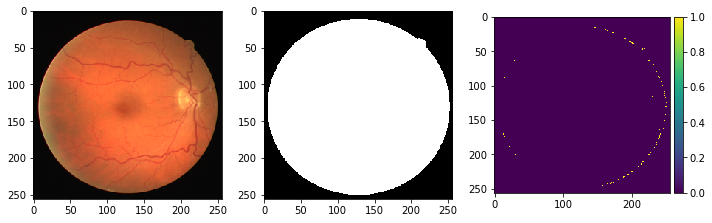

Accuracy= 0.29711914 Precision= 1.0 Recall= 0.009738375 MeanIoU= 0.15098262 DiceCoefficient= 0.09441885232627101 HD= 15.231546211727817 MyIoU= 0.0 MAE= 0.70288086


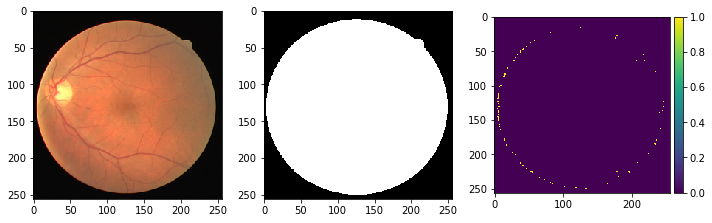

Accuracy= 0.30384827 Precision= 1.0 Recall= 0.010626071 MeanIoU= 0.15461507 DiceCoefficient= 0.09697977156974957 HD= 15.297058540778355 MyIoU= 0.0 MAE= 0.69615173


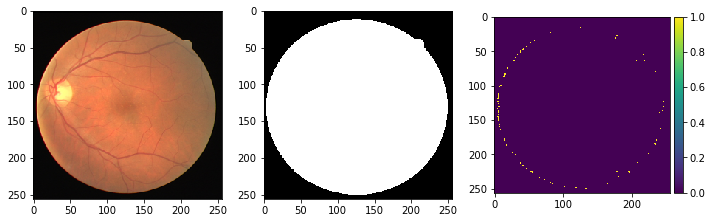

Accuracy= 0.30384827 Precision= 1.0 Recall= 0.010626071 MeanIoU= 0.15461507 DiceCoefficient= 0.09697977156974957 HD= 15.297058540778355 MyIoU= 0.0 MAE= 0.69615173


In [263]:
x=0

xx = [1,0,0]
for i in range(3):
    plt.figure(figsize=(10,10))
    #ix = random.randint(0, len(preds_train))
    ix = xx[i]
    #print(ix)
    #ix = 58
    plt.subplot(3,3,x+1)
    imshow(X_train[:int(X_train.shape[0]*(1-val_split))][ix].astype('uint8'))
    #plt.title('Image')

    plt.subplot(3,3,x+2)
    imshow(np.squeeze(Y_train[:int(Y_train.shape[0]*(1-val_split))][ix]))
    #plt.title('Mask')

    plt.subplot(3,3,x+3)
    imshow(np.squeeze(preds_train_t[ix]))
    #plt.title('Predicted Mask')
    #plt.show()
    
    plt.show()
    evalResult(Y_train[:int(Y_train.shape[0]*(1-val_split))][ix], preds_train_t[ix])
    x = x+3

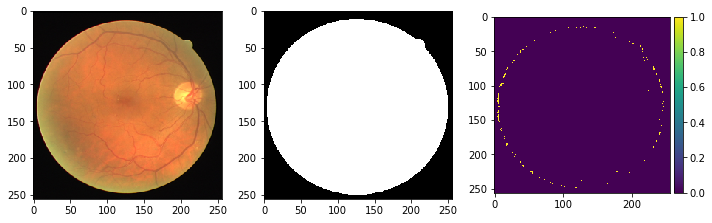

Accuracy= 0.3046112 Precision= 0.9983165 Recall= 0.012845229 MeanIoU= 0.15555325 DiceCoefficient= 0.10165109334047884 HD= 15.264337522473747 MyIoU= 0.0 MAE= 0.6953888


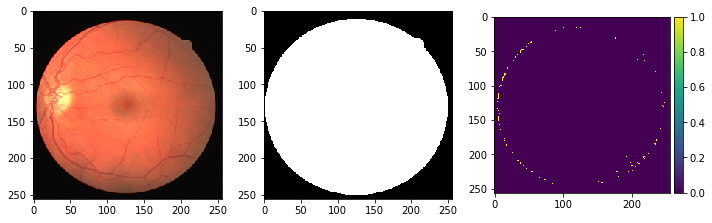

Accuracy= 0.29751587 Precision= 1.0 Recall= 0.01121134 MeanIoU= 0.15154347 DiceCoefficient= 0.0970958077632531 HD= 15.297058540778355 MyIoU= 0.0 MAE= 0.70248413


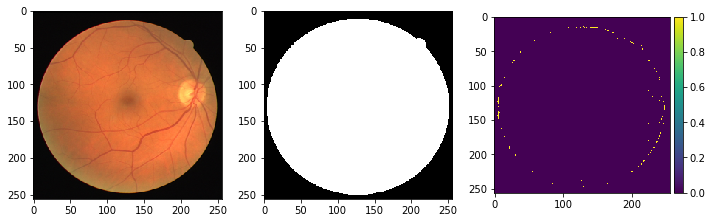

Accuracy= 0.29862976 Precision= 1.0 Recall= 0.011866629 MeanIoU= 0.15226933 DiceCoefficient= 0.09986816744822136 HD= 15.165750888103101 MyIoU= 0.0 MAE= 0.70137024


In [264]:
x=0
xx = [16,10,15]
for i in range(3):
    plt.figure(figsize=(10,10))
    #ix = random.randint(0, len(preds_train))
    ix = xx[i]
    #print(ix)
    #ix = 58
    plt.subplot(3,3,x+1)
    imshow(X_test[ix].astype('uint8'))
    #plt.title('Image')

    plt.subplot(3,3,x+2)
    imshow(np.squeeze(Y_test[ix]))
    #plt.title('Mask')

    plt.subplot(3,3,x+3)
    imshow(np.squeeze(preds_test_t[ix]))
    #plt.title('Predicted Mask')
    #plt.show()
    
    plt.show()
    evalResult(Y_test[ix], preds_test_t[ix])
    x = x+3
